# Saravanan, Karthik Sundaram -- Homework 3


**Due in class on Wed 6th March**

We study Table 13.2 on p240 of Lange and Chapter 13 Question 11 (p240) and Chapter 14, Example 14.10.1 (p264).

The table contains counts of the number of days a given number of deaths occurred. 

In [1]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
freq = np.array([162,267,271,185,111,61,27,8,3,1])

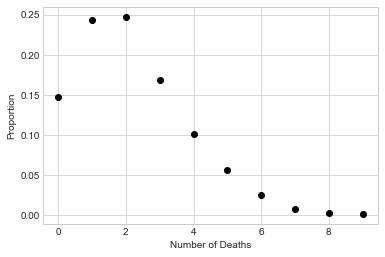

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

## proportion of different number of deaths
plt.plot(np.arange(freq.size), freq/np.sum(freq), 'o', color='black')
plt.xlabel("Number of Deaths")
plt.ylabel("Proportion");

## Problem 1

Confirm Lange's claim in question 11 that "A Poisson distribution gives a poor fit to these data . . ." by computing the MLE of the Poisson parameter $\lambda$ (this should be done by hand using calculus) and plotting the resulting probability mass function over the observed data. They should be a bit discrepant (thus justifying the claim).

Single parameter Poisson distribution - likelihood function:
$$ f(x_1,...,x_9 | \lambda) = \prod_{i=0}^9 \left[ \frac{e^{-\lambda}\lambda^i}{i!} \right]^{n_i}  $$
Log-likelihood :
$$ \log f = -\lambda\sum n_i + \log\lambda\sum in_i - \log\left( \prod (i!)^{n_i} \right) $$
Calculating the Maximum Likelihood,
$$ \frac{d\log f}{d\lambda} = -\sum n_i + \frac{\sum in_i}{\lambda} = 0 $$
yields the MLE for $\lambda$
$$ \hat{\lambda} = \frac{\sum in_i}{\sum n_i} $$


lambda derived from manual calcualtion:  2.156934306569343


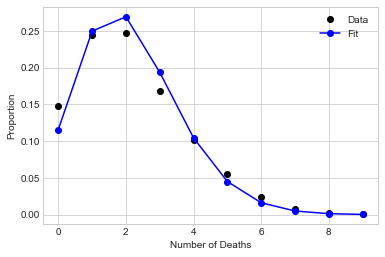

In [3]:
import numpy as np
from scipy.stats import poisson

no = np.arange(0,len(freq))
MLE_lambda = sum(no*freq)/sum(freq)
poisson_MLE = poisson.pmf(no,MLE_lambda)


%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(no, freq/np.sum(freq), 'o', color='black', label='Data')
plt.plot(no, poisson_MLE, '-o', color='blue', label='Fit')
plt.xlabel("Number of Deaths")
plt.ylabel("Proportion")
plt.legend(loc='best')
print("lambda derived from manual calcualtion: ", MLE_lambda)

Discrepecy is visible from the above overlaid plot on the original points

## Problem 2

Fit the $\alpha$, $\mu_1$ and $\mu_2$ parameters for the mixture of two Poissons model proposed in Question 11 using a gradient ascent algorithm. You must write your own fitting code (you cannot use `scipy optimize` or R `optim`). Discuss how you select starting parameters and monitor convergence. Include a plot to illustrate the convergence for different starting values of the parameters. You can confirm your results by also using Python or R built in optimizers.

In [4]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [5]:
def loglike(no,freq,p):
    a,lam1,lam2 = p
    return np.sum(freq*np.log(a*poisson.pmf(no,lam1)+(1-a)*poisson.pmf(no,lam2)))

def diff_a(no,freq,p):
    a,lam1,lam2 = p
    return np.sum((freq*(poisson.pmf(no,lam1)-poisson.pmf(no,lam2)))/(a*poisson.pmf(no,lam1)+(1-a)*poisson.pmf(no,lam2)))

def diff_l1(no,freq,p):
    a,lam1,lam2 = p
    return np.sum((a*freq*(-poisson.pmf(no,lam1)+poisson.pmf(no-1,lam1)))/(a*poisson.pmf(no,lam1)+(1-a)*poisson.pmf(no,lam2)))

def diff_l2(no,freq,p):
    a,lam1,lam2 = p
    return np.sum(((1-a)*freq*(-poisson.pmf(no,lam2)+poisson.pmf(no-1,lam2)))/(a*poisson.pmf(no,lam1)+(1-a)*poisson.pmf(no,lam2)))

def grad(no,freq,p):
    return np.array([diff_a(no,freq,p), diff_l1(no,freq,p), diff_l2(no,freq,p)])

In [6]:
def gradient_ascent(p): #p is the starting value
    a = p[0]
    lam1 = p[1]
    lam2 = p[2]
    p1=[]
    p1=p.copy()
    Niter = 5000
    param_iter = []
    gradient_ascent_iterations = 0
    param_iter.append(p)
    for i in range(1,Niter):
        #print("lambda1:"  + str(lam1) + " lambda2: " + str(lam2)+ " alpha: " + str(a))
        g_a,g_lam1,g_lam2 =grad(no,freq,p) #gradient
        #print("",g_a,g_lam1,g_lam2)
        c = 0.001
        half = True
        while half:
            l1 = lam1 + c*g_lam1
            l2 = lam2 + c*g_lam2
            alpha = a + c*g_a
            if loglike(no,freq,[alpha,l1,l2]) < loglike(no,freq,p):
                print("halved")
                c = c / 2.0
            else:
                p=[alpha,l1,l2]
                lam1 = p[1]
                lam2 = p[2]
                a = p[0]
                half = False
        param_iter.append(p)
        if(i!=1):
                if(abs(param_iter[-1][0]-param_iter[-2][0])+abs(param_iter[-1][1]-param_iter[-2][1])+abs(param_iter[-1][1]-param_iter[-2][1]) <0.00001):
                    gradient_ascent_iterations = i
                    break
    print("alpha:",p[0])
    print("lambda1:",p[1])
    print("lambda2:",p[2])
    
    ## PLOTTED 2 PARAMETERS AT A TIME
    
    
    lam1_grid = np.linspace(0.0,3.0,100)
    lam2_grid = np.linspace(0.0,3.0,100)

    lam1_grid , lam2_grid = np.meshgrid(lam1_grid , lam2_grid)

    XYpairs = np.vstack([ lam1_grid.reshape(-1), lam2_grid.reshape(-1) ])
    Z = np.apply_along_axis(lambda z: loglike(no,freq,[a,z[0],z[1]]),0,XYpairs)
    Z = Z.reshape((100,100))

    plt.style.use('seaborn-white')
    plt.contour(lam1_grid , lam2_grid, Z,50, colors='black');
    plt.plot(p1[1],p1[2],'o',color='red');
    plt.xlabel(r'$\lambda_1$')
    plt.ylabel(r'$\lambda_2$')
    plt.plot([i[1] for i in param_iter],[i[2] for i in param_iter])

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(lam1_grid, lam2_grid, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                    cmap=cm.coolwarm)

    cset = ax.contourf(lam1_grid, lam2_grid, Z, zdir='z', offset=150, cmap=cm.coolwarm)
    ax.set_zlim(0,Z.max())
    ax.view_init(27, -21)
    plt.xlabel(r'$\lambda_1$')
    plt.ylabel(r'$\lambda_2$')
    #ax.plot([i[1] for i in param_iter],[i[2] for i in param_iter], zs=0, zdir='z', label='curve in (x,y)')
    #ax.plot_surface([i[1] for i in param_iter],[i[2] for i in param_iter],'k')
    print(Z.min())
    plt.show()

    lam1_grid = np.linspace(0.0,3.0,100)
    lam2_grid = np.linspace(0.0,3.0,100)

    lam1_grid , lam2_grid = np.meshgrid(lam1_grid , lam2_grid)

    XYpairs = np.vstack([ lam1_grid.reshape(-1), lam2_grid.reshape(-1) ])
    Z = np.apply_along_axis(lambda z: loglike(no,freq,[a,z[0],z[1]]),0,XYpairs)
    Z = Z.reshape((100,100))

    plt.style.use('seaborn-white')
    plt.contour(lam1_grid , lam2_grid, Z,50, colors='black');
    plt.plot(p1[1],p1[2],'o',color='red');
    plt.xlabel(r'$\lambda_1$')
    plt.ylabel(r'$\lambda_2$')
    plt.plot([i[1] for i in param_iter],[i[2] for i in param_iter])

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(lam1_grid, lam2_grid, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                    cmap=cm.coolwarm)

    cset = ax.contourf(lam1_grid, lam2_grid, Z, zdir='z', offset=150, cmap=cm.coolwarm)
    ax.set_zlim(0,Z.max())
    ax.view_init(27, -21)
    plt.xlabel(r'$\lambda_1$')
    plt.ylabel(r'$\lambda_2$')
    #ax.plot([i[1] for i in param_iter],[i[2] for i in param_iter], zs=0, zdir='z', label='curve in (x,y)')
    #ax.plot_surface([i[1] for i in param_iter],[i[2] for i in param_iter],'k')
    print(Z.min())
    plt.show()

    lam1_grid = np.linspace(0.0,3.0,100)
    a_grid = np.linspace(0.0,1.0,100)

    lam1_grid , a_grid = np.meshgrid(lam1_grid , a_grid)

    XYpairs = np.vstack([ lam1_grid.reshape(-1), a_grid.reshape(-1) ])
    Z = np.apply_along_axis(lambda z: loglike(no,freq,[z[1],z[0],lam2]),0,XYpairs)
    Z = Z.reshape((100,100))

    plt.style.use('seaborn-white')
    plt.contour(lam1_grid , a_grid, Z,50, colors='black');
    plt.plot(p1[1],p1[0],'o',color='red');
    plt.xlabel(r'$\lambda_1$')
    plt.ylabel(r'$\alpha$')
    plt.plot([i[1] for i in param_iter],[i[0] for i in param_iter])

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(lam1_grid , a_grid, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                    cmap=cm.coolwarm)

    cset = ax.contourf(lam1_grid , a_grid, Z, zdir='z', offset=150, cmap=cm.coolwarm)

    ax.set_zlim(0,Z.max())

    ax.view_init(27, -21)
    plt.xlabel(r'$\lambda_1$')
    plt.ylabel(r'$\alpha$')
    plt.show()

    lam2_grid = np.linspace(0.0,3.0,100)
    a_grid = np.linspace(0.0,1.0,100)

    lam2_grid , a_grid = np.meshgrid(lam2_grid , a_grid)

    XYpairs = np.vstack([ lam2_grid.reshape(-1), a_grid.reshape(-1) ])
    Z = np.apply_along_axis(lambda z: loglike(no,freq,[z[1],lam1,z[0]]),0,XYpairs)
    Z = Z.reshape((100,100))

    plt.style.use('seaborn-white')
    plt.contour(lam2_grid , a_grid, Z,50, colors='black');
    plt.plot(p1[2],p1[0],'o',color='red');
    plt.xlabel(r'$\lambda_2$')
    plt.ylabel(r'$\alpha$')
    plt.plot([i[2] for i in param_iter],[i[0] for i in param_iter])


    ### PLOT 2: 3-D
    # Create a surface plot and projected filled contour plot under it.
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(lam2_grid , a_grid, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                    cmap=cm.coolwarm)

    cset = ax.contourf(lam2_grid , a_grid, Z, zdir='z', offset=150, cmap=cm.coolwarm)

    ax.set_zlim(0,Z.max())

    ax.view_init(27, -21)
    plt.xlabel(r'$\lambda_2$')
    plt.ylabel(r'$\alpha$')
    plt.show()

Gradient Ascent algorithm run with the starting value given in the book

alpha: 0.3594279026949423
lambda1: 1.2552763990592348
lambda2: 2.662842615686639
-inf


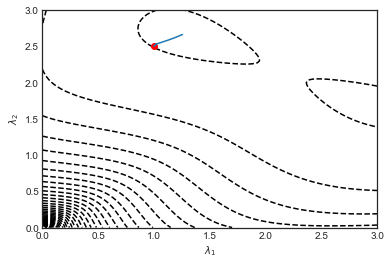

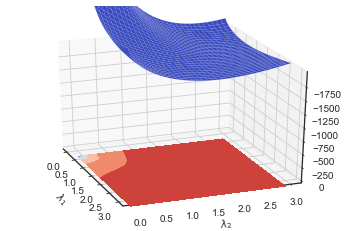

-inf


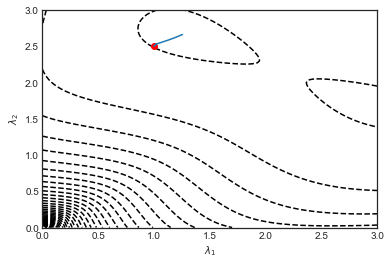

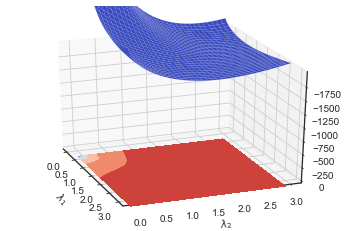

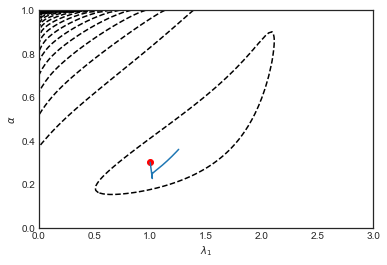

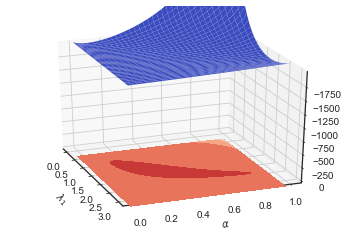

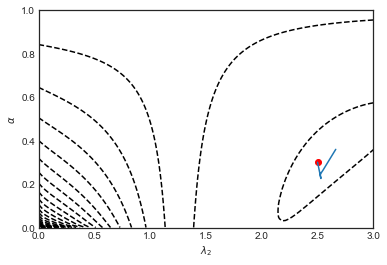

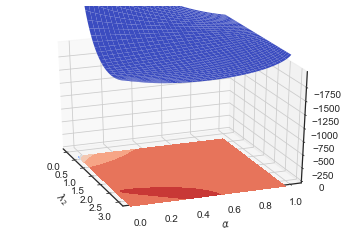

In [7]:
gradient_ascent([0.3,1.0,2.5])  

Few other starting points chosen around the actual starting point given in the book. 
I have not included certain cases which do not converge to the same point as the book

starting point (alpha,lambda1,lambda2): [0.3, 1.0, 2.5]
alpha: 0.3594279026949423
lambda1: 1.2552763990592348
lambda2: 2.662842615686639
-inf


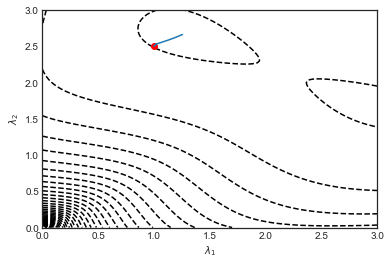

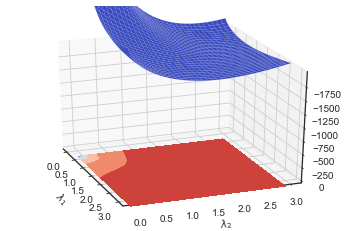

-inf


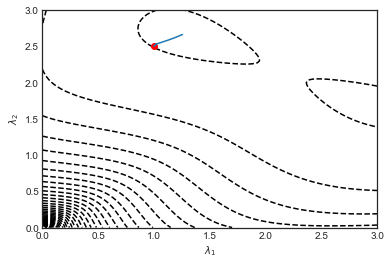

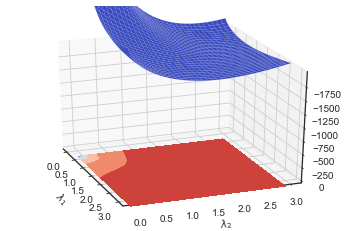

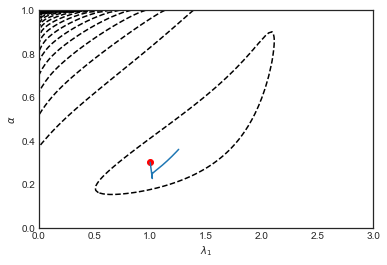

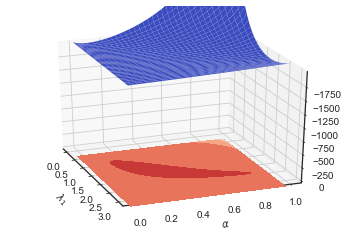

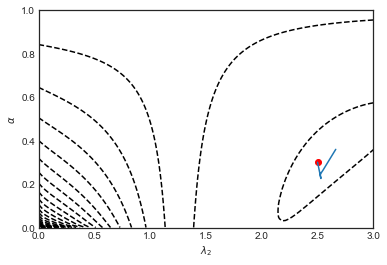

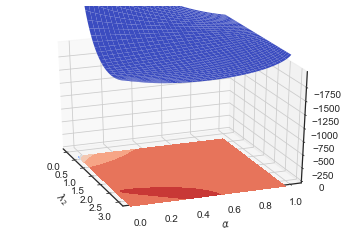

In [8]:
print("starting point (alpha,lambda1,lambda2):",[0.3,1.0,2.5])
gradient_ascent([0.3,1.0,2.5])


starting point (alpha,lambda1,lambda2): [0.3, 2.0, 2.5]
alpha: 0.36034330441706336
lambda1: 1.2569134840055938
lambda2: 2.6639668392320064
-inf


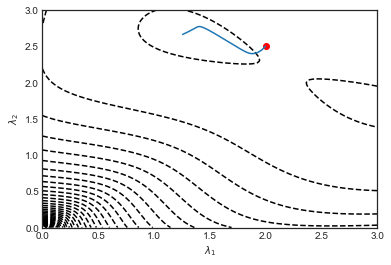

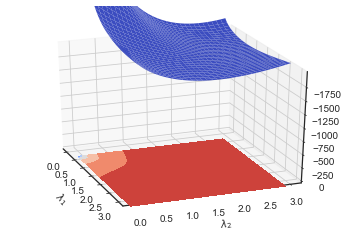

-inf


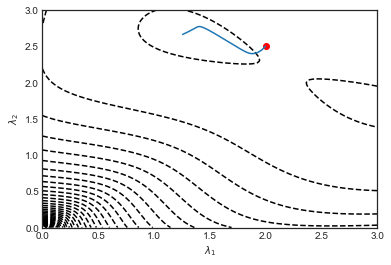

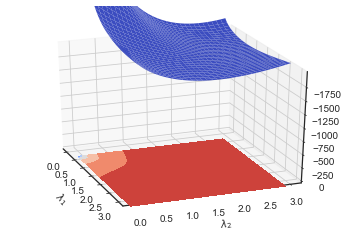

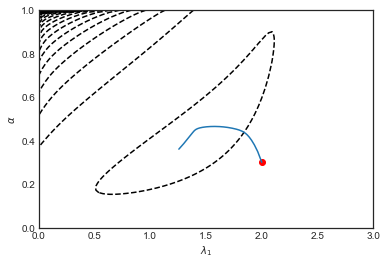

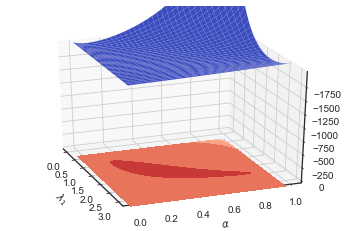

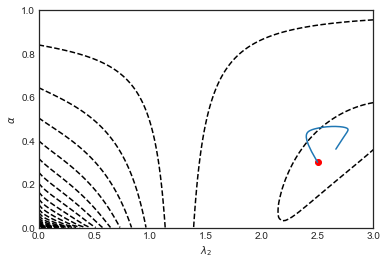

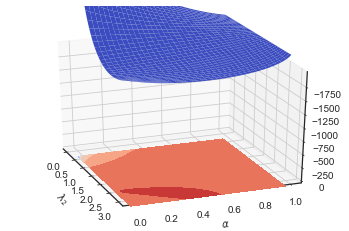

In [9]:
print("starting point (alpha,lambda1,lambda2):",[0.3,2.0,2.5])
gradient_ascent([0.3,2.0,2.5])


starting point (alpha,lambda1,lambda2): [0.4, 1.0, 2.0]
alpha: 0.3594269961423074
lambda1: 1.2552747756996838
lambda2: 2.662841502794616
-inf


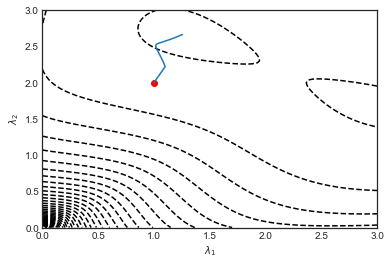

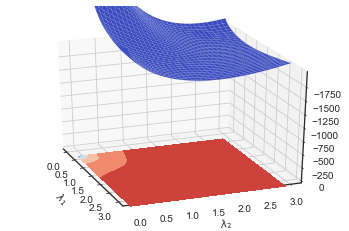

-inf


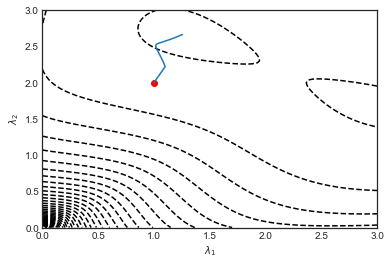

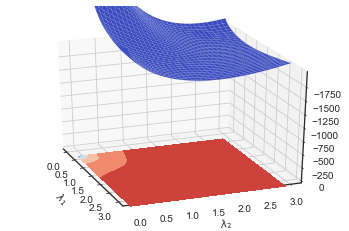

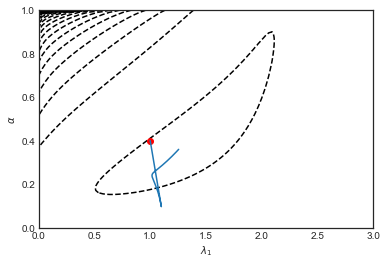

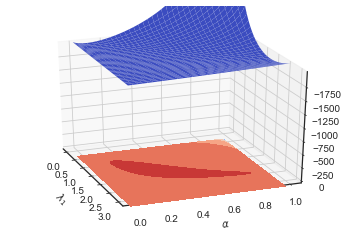

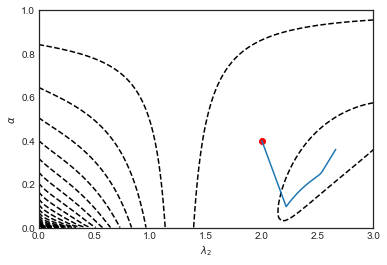

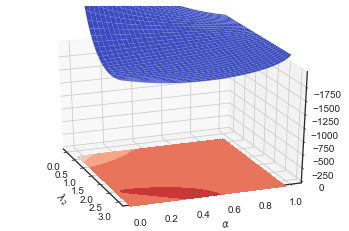

In [10]:
print("starting point (alpha,lambda1,lambda2):",[0.4,1.0,2.0])
gradient_ascent([0.4,1.0,2.0])


starting point (alpha,lambda1,lambda2): [0.5, 1.0, 3]
alpha: 0.3603436706646026
lambda1: 1.256914138148581
lambda2: 2.6639672892158948
-inf


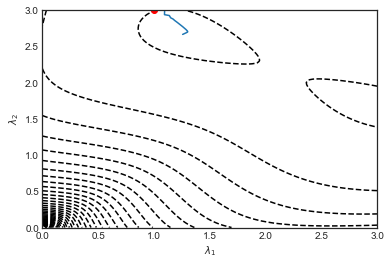

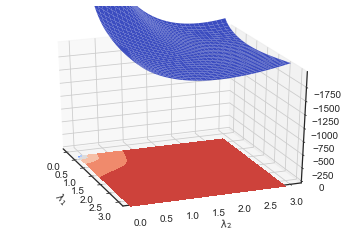

-inf


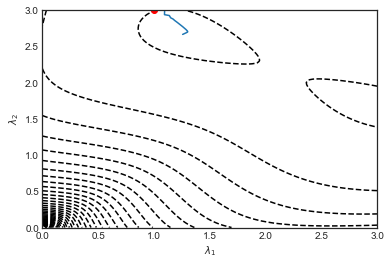

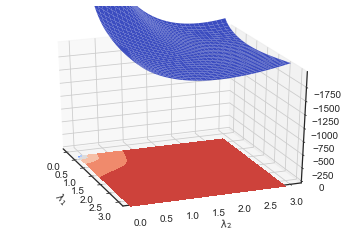

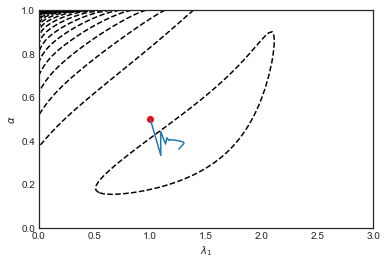

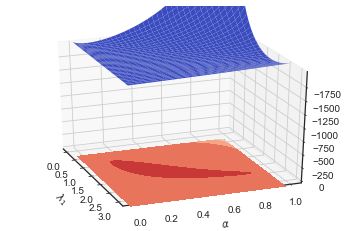

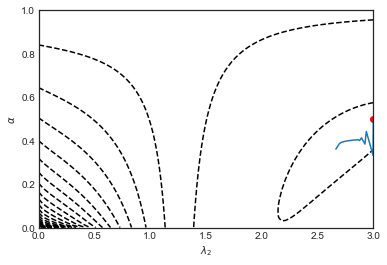

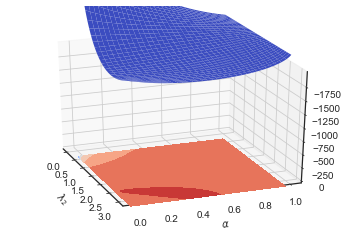

In [11]:
print("starting point (alpha,lambda1,lambda2):",[0.5,1.0,3])
gradient_ascent([0.5,1.0,3])

In all the above cases of different starting values of the parameters, the algorithm seems to converge towards the maximum likelihood
value or least loss function

In [12]:
p=[0.3,1.0,2.5] # given starting parameters in the book
a = p[0]
lam1 = p[1]
lam2 = p[2]
p1=[]
p1=p.copy()
Niter = 5000
param_iter = []
gradient_ascent_iterations = 0


In [13]:
import time 
start = time.time()
param_iter.append(p)
for i in range(1,Niter):
    #print("lambda1:"  + str(lam1) + " lambda2: " + str(lam2)+ " alpha: " + str(a))
    g_a,g_lam1,g_lam2 =grad(no,freq,p) #gradient
    #print("",g_a,g_lam1,g_lam2)
    c = 0.001
    half = True
    while half:
        l1 = lam1 + c*g_lam1
        l2 = lam2 + c*g_lam2
        alpha = a + c*g_a
        if loglike(no,freq,[alpha,l1,l2]) < loglike(no,freq,p):
            print("halved")
            c = c / 2.0
        else:
            p=[alpha,l1,l2]
            lam1 = p[1]
            lam2 = p[2]
            a = p[0]
            half = False
    param_iter.append(p)
    if(i!=1):
            if(abs(param_iter[-1][0]-param_iter[-2][0])+abs(param_iter[-1][1]-param_iter[-2][1])+abs(param_iter[-1][1]-param_iter[-2][1]) <0.00001):
                gradient_ascent_iterations = i
                break
                
end = time.time()
grad_asc_time = end-start

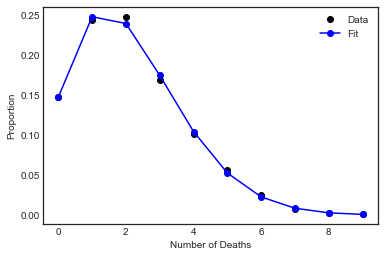

In [14]:

freq_fit = p[0]*poisson.pmf(no, p[1])+(1-a)*poisson.pmf(no, p[2])

plt.plot(no, freq/np.sum(freq), 'o', color='black', label='Data')
plt.plot(no, freq_fit, '-o', color='blue', label='Fit')
plt.xlabel("Number of Deaths")
plt.ylabel("Proportion")
plt.legend(loc='best');

## Problem 3

Implement the EM algorithm approach detailed in Question 11 to fit the parameter $\alpha$, $\mu_1$ and $\mu_2$. Compare the number of steps and the computation time of the EM algorithm to the gradient ascent method you used in Problem 2.

In [15]:

knum = 2
d = 1


In [16]:

dat_ls=[]
for i in range(0,len(freq)):
    dat_ls=dat_ls+ freq[i]*[i]
#dat_ls
n = len(dat_ls)

In [17]:
import numpy as np
import math

def pois_fn(x,lam):
    return((lam**x)*np.exp(-lam)/math.factorial(x))
    
def comp_fn(mu,pi,x,k):
    return pi[k]*pois_fn(x,mu[k])
    
def Ez_fun(mu,pi,x,k):
    return comp_fn(mu,pi,x,k)/sum(list(map(lambda k:comp_fn(mu,pi,x,k) ,list(range(0,knum)) )))

In [18]:
# Initialize the parameters 
mu=[1.0,2.5]


# pi = np.repeat(1/knum,knum) #[1/2,1/2]
pi = [0.3,0.7] #[1/2,1/2]
# EM algorithm. 

mu_list=[]
pi_list=[]
EM_algo_iterations = 0

pi,mu,n

([0.3, 0.7], [1.0, 2.5], 1096)

In [19]:
start = time.time()

Ez_vals = np.full([n,knum], np.nan) 
for iter in range(1,3000):
  # E-step
    for k in range(0,knum):
        Ez_vals[:,k] = list(map(lambda x:Ez_fun(mu,pi,x,k) ,dat_ls )) #P(pi of which fn dat came from/parameters)
  
  # M-step
    for k in range(0,knum):
        nk = sum(Ez_vals[:,k]) 
        mu[k] = sum(map(lambda x,y:x*y,Ez_vals[:,k],dat_ls))/nk 
        pi[k] = nk/n
    mu_copy = []
    mu_copy = mu.copy()
    mu_list.append(mu_copy)
    
    pi_copy = []
    pi_copy = pi.copy()
    pi_list.append(pi_copy)
    

    if(iter!=1):
        if(abs(mu_list[-1][0]-mu_list[-2][0])+abs(mu_list[-1][1]-mu_list[-2][1]) +abs(pi_list[-1][0]-pi_list[-2][0]) <0.0000001):
            EM_algo_iterations = iter
            break            
end = time.time()

In [20]:
print("alpha:",pi[0])
print("lambda1:",mu[0])
print("lambda2:",mu[1])

alpha: 0.35987961262332024
lambda1: 1.2560850458412653
lambda2: 2.6633972928701266


In [21]:
EM_algo_time = end-start

## comaprison of the Gradient Ascent & EM (Expectation Maximization) algorithms using the same starting values and ending conditions

In [22]:
print("gradient ascent time:",grad_asc_time)
print("gradient ascent iterations:",gradient_ascent_iterations)

print("alpha:",pi[0])
print("lambda1:",mu[0])
print("lambda2:",mu[1])

gradient ascent time: 2.0312340259552
gradient ascent iterations: 1175
alpha: 0.35987961262332024
lambda1: 1.2560850458412653
lambda2: 2.6633972928701266


In [23]:
print("EM algorithm time:",EM_algo_time)
print("EM algorithm iterations:",EM_algo_iterations)

print("alpha:",p[0])
print("lambda1:",p[1])
print("lambda2:",p[2])

EM algorithm time: 83.9544529914856
EM algorithm iterations: 2176
alpha: 0.3594279026949423
lambda1: 1.2552763990592348
lambda2: 2.662842615686639


It seems that EM algorithm is slower and takes more iterations to converge to the final value given the same starting values and ending conditions